In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error

In [ ]:
%%time
# ~18mins

# Execute CURATE without pop tau
execute_CURATE()

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

In [18]:
"""Bar plot of percentage of ideal/over/under predictions, by method"""

df = ideal_over_under_pred()

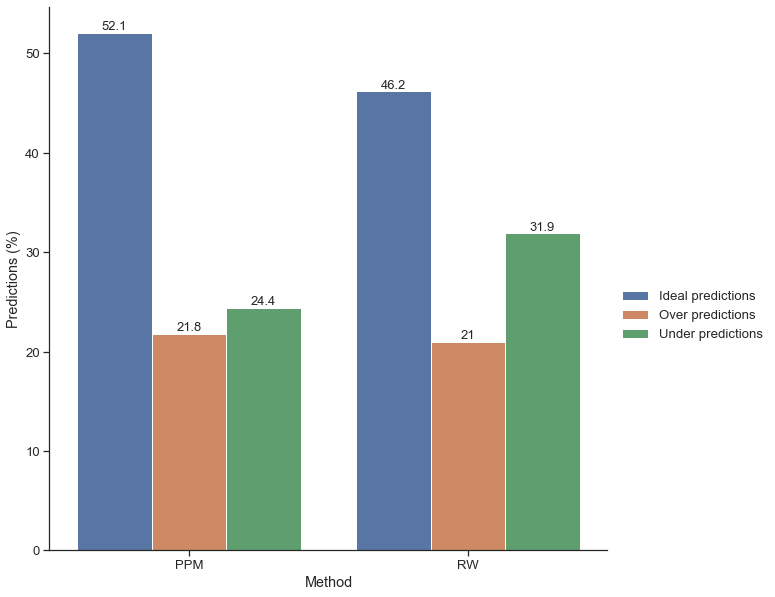

In [32]:
dat = df.copy()

# Subset PPM and RW method
dat = dat[(dat.pop_tau=='no pop tau') & ((dat.method=='L_PPM_wo_origin') | (dat.method=='L_RW_wo_origin'))]

# Rename columns
dat = dat.rename(columns={'result':'Result', 'method':'Method', 'perc_predictions':'Predictions (%)'})
dat['Method'] = dat['Method'].map({'L_PPM_wo_origin':'PPM', 'L_RW_wo_origin':'RW'})
dat['Result'] = dat['Result'].map({'ideal':'Ideal predictions', 'over':'Over predictions', 'under':'Under predictions'})
dat['Predictions (%)'] = dat['Predictions (%)'].round(1)

# Plot
fig, ax = plt.subplots(figsize=(10,10))

sns.set(font_scale=1.2, style='white', rc={"figure.figsize": (16,10), "xtick.bottom" : True, "ytick.left" : True})

ax = sns.barplot(data=dat, x='Method', y='Predictions (%)', hue='Result')
sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(1.3,0.5), loc='upper right')

# Label bars
for container in ax.containers:
    ax.bar_label(container, fontsize=13)

plt.savefig('ideal_over_under_PPM_RW.png', dpi=500, facecolor='w', bbox_inches='tight')

In [ ]:
dat = df.copy()
dat

In [ ]:
df = CURATE_could_be_useful()

In [ ]:
dat = df.copy()

# Subset chosen results
dat = dat[(dat.wrong_range==False) & (dat.acceptable_deviation==True)]

# Subset columns
dat = dat[['method']]

In [ ]:
dat = CURATE_could_be_useful()

method_string = ['PPM', 'RW']
method_dat = []

for j in range(len(method_string)):

    # Subset selected PPM/RW method
    dat = dat[dat['method']==('L_' + method_string[j] + '_wo_origin')]

    # Create column for adapted within range to indicate if data point
    # could have been within range if augmented by CURATE
    dat['adapted_within_range'] = dat.within_range
    dat = dat.reset_index()

    for i in range(len(dat)):
        if (dat.CURATE_could_be_useful[i]==True):
            dat.loc[i, 'adapted_within_range'] = 'Potentially True with CURATE_' + method_string[j]
        elif (dat.within_range[i]==True and (dat.wrong_range[i]==True or dat.acceptable_deviation[i]==False)):
            dat.loc[i, 'adapted_within_range'] = 'Potentially False with CURATE_' + method_string[j]
        else:
            dat.loc[i, 'adapted_within_range'] = 'CURATE_no_impact'

    # Subset columns
    dat = dat[['pred_day', 'patient', 'adapted_within_range']]

    # Rename columns
    dat.columns = ['day', 'patient', 'adapted_within_range']

    # Only keep those that are affected by SOC
    dat = dat[dat.adapted_within_range != 'CURATE_no_impact']
    dat = dat[['day', 'patient', 'adapted_within_range']]

    # Import data with all data including non-ideal data
    dat_all_data = indiv_profiles_all_data(plot=False)

    # Merge both dataframes
    combined_dat = dat_all_data.merge(dat, how='left', on=['patient', 'day'])
    combined_dat.loc[combined_dat['adapted_within_range'].isnull(),'adapted_within_range'] = \
    combined_dat['within_range']
    combined_dat['adapted_within_range'] = combined_dat['adapted_within_range'].astype(str)

    # Rename adapted_within_range
    for i in range(len(combined_dat)):
        if combined_dat.adapted_within_range[i] == 'Potentially True with CURATE_' + method_string[j]:
            combined_dat.loc[i, 'adapted_within_range'] = 'True (' + method_string[j] + '_assisted)'
        elif combined_dat.adapted_within_range[i] == 'Potentially False with CURATE_' + method_string[j]:
            combined_dat.loc[i, 'adapted_within_range'] = 'False (' + method_string[j] + '_assisted)'

    # Plot
    sns.set(font_scale=1.2, rc={'figure.figsize':(16,10)})
    sns.set_style('white')
    hue_order = ['True', 'False', 'True (' + method_string[j] + '_assisted)', 'False (' + method_string[j] + '_assisted)']
    palette = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[2],\
              sns.color_palette()[3]]

    g = sns.relplot(data=combined_dat, x='day', y='response', hue='adapted_within_range',\
                    hue_order=hue_order, col='patient', palette=palette,\
                    col_wrap=4, style='dose_range', height=1.5, aspect=1.5, s=60)

    g.map(plt.axhline, y=10, ls='--', c='black')
    g.map(plt.axhline, y=8, ls='--', c='black')

    plt.savefig('indiv_pt_profile_adapted_' + method_string[j] + '.png', dpi=500, facecolor='w', bbox_inches='tight')

    method_dat.append(combined_dat)

In [ ]:
dat = read_file_and_remove_unprocessed_pop_tau()

In [ ]:
df = method_dat.copy()
final_df, CURATE_may_help = CURATE_assisted_result_distribution(df, 'PPM')
# final_df

CURATE_may_help

In [ ]:
dat = df.copy()
dat

In [ ]:
df = CURATE_could_be_useful()

In [ ]:
dat, string = CURATE_simulated_results_PPM_RW()

In [ ]:
method_dat = dat.copy()
method_string = string.copy()
final_df_list = CURATE_assisted_result_distribution(method_dat, method_string)